In [3]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch, gc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
# from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from captum.attr import IntegratedGradients, GradientShap, ClassifierOutputTarget , LayerGradCam  
import torch.nn.functional as F
import torch.nn as nn

import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL
from sklearn.metrics import pairwise_distances, accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score




ImportError: cannot import name 'ClassifierOutputTarget' from 'captum.attr' (/home/jovyan/.local/lib/python3.10/site-packages/captum/attr/__init__.py)

In [ ]:
#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.set_num_threads(4)  # 4 threads per worker

In [12]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

# Loop through all available GPUs
for gpu_id in range(torch.cuda.device_count()):
    torch.cuda.set_device(gpu_id)  # Set the current GPU
    torch.cuda.empty_cache()  
    torch.cuda.ipc_collect()
     # Clear the cache for this GPU
    gc.collect()                   # Trigger garbage collection

print("All GPU memory has been cleared.")


All GPU memory has been cleared.


In [2]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# workers = multiprocessing.cpu_count()
workers = 30
print(f"Number of workers: {workers}")
# Set the number of workers for DataLoader

# Cifar transform: resize to 224x224, convert to tensor, normalize
cifar_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

cifar_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_train_transform = transforms.Compose([
    # Apply augmentations on the original 96x96 images FIRST
    transforms.RandomResizedCrop(
        size=96,  # Operate on the native PCam resolution (96x96)
        scale=(0.8, 1.0),  # Randomly crop 80-100% of the original area
        interpolation=transforms.InterpolationMode.BICUBIC  # Smoother scaling
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    # Resize to 224x224 AFTER augmentations (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    # Conservative color augmentations (medical images are sensitive to color shifts)
    transforms.ColorJitter(
        brightness=0.1,  # Keep subtle for H&E-stained tissue
        contrast=0.1,
        saturation=0.0,   # Avoid altering saturation (critical for PCam)
        hue=0.0
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_test_transform = transforms.Compose([
    # Resize to 224x224 (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=cifar_test_transform
)

# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=True,
    transform=pcam_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=True,
    transform=pcam_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=True,
    transform=pcam_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
batch_size = 512
# cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)

# pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=True)

print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Number of workers: 30
CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.


In [4]:


def create_random_subset(dataset, subset_length, seed=42):
    """
    Quickly creates a random subset of the dataset.
    """
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), subset_length, replace=False)
    return Subset(dataset, indices)

# Create training and test subsets
pcam_train_subset = create_random_subset(pcam_train, 5000)
pcam_test_subset = create_random_subset(pcam_test, 1000)
pcam_val_subset = create_random_subset(pcam_val, 1000)

# Create DataLoaders
pcam_train_loader = DataLoader(
    pcam_train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

pcam_test_loader = DataLoader(
    pcam_test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

pcam_val_loader = DataLoader(
    pcam_val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train subset size: {len(pcam_train_subset)}")
print(f"Test subset size: {len(pcam_test_subset)}")
print(f"Validation subset size: {len(pcam_val_subset)}")
NUM_CLASSES = 2
CLASS_NAMES = ["Normal", "Cancer"]


Train subset size: 5000
Test subset size: 1000
Validation subset size: 1000


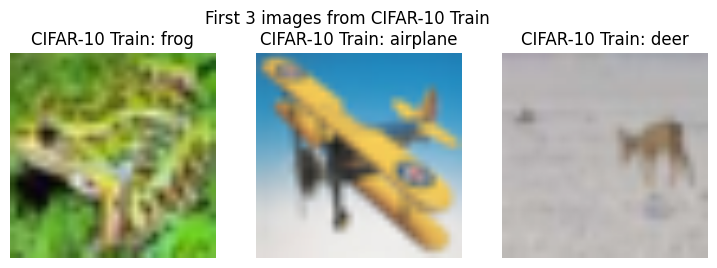

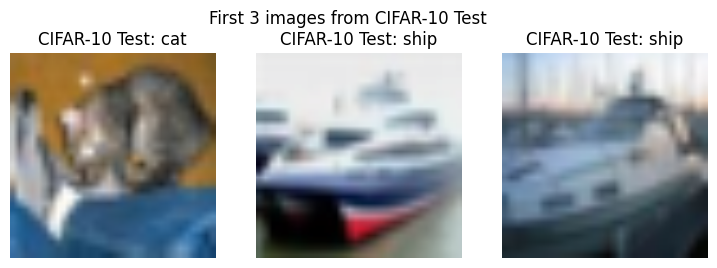

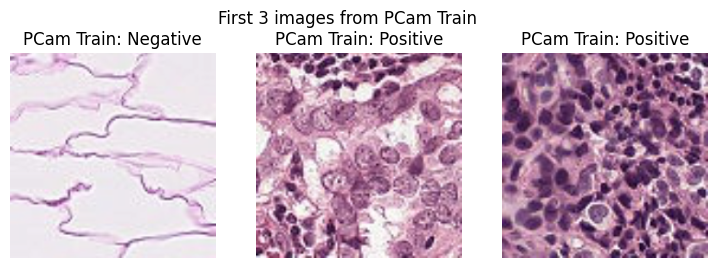

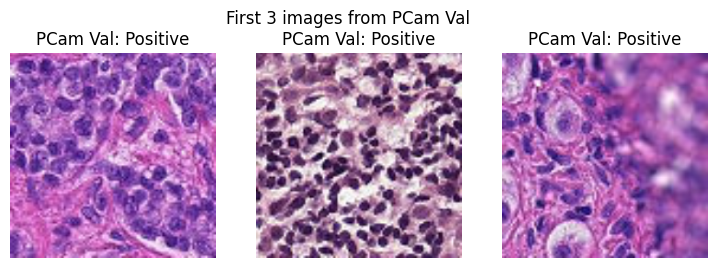

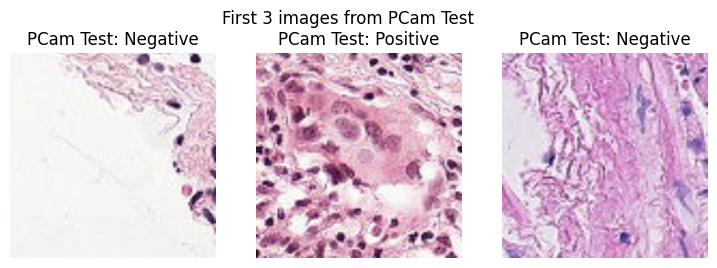

In [4]:
# Helper function to denormalize and show an image
def imshow(img, mean=IMAGENET_MEAN, std=IMAGENET_STD, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Function to show first 3 images from a DataLoader
def show_first_n_images(dataloader, class_names, dataset_name, n=3):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize=(n * 3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        if class_names is not None:
            plt.title(f"{dataset_name}: {class_names[labels[i]]}")
        else:
            plt.title(f"{dataset_name}: Label {labels[i].item()}")
    plt.suptitle(f"First {n} images from {dataset_name}")
    plt.show()

# Class names for CIFAR-10 and PCam
cifar10_classes = cifar10_train.classes
pcam_classes = ['Negative', 'Positive']

# Show images from each DataLoader
show_first_n_images(cifar10_train_loader, cifar10_classes, "CIFAR-10 Train")
show_first_n_images(cifar10_test_loader, cifar10_classes, "CIFAR-10 Test")
show_first_n_images(pcam_train_loader, pcam_classes, "PCam Train")
show_first_n_images(pcam_val_loader, pcam_classes, "PCam Val")
show_first_n_images(pcam_test_loader, pcam_classes, "PCam Test")


In [5]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize models for CIFAR-10 and PCam
# cifar_model = initialize_resnet34(num_classes=10, device=device)
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 2 classes on cuda:0 (DataParallel=True)


<h1> This code for AL and XAI sepreatly. </h1>

In [6]:


# Helper: PyTorch model wrapper for scikit-activeml (DEVICE FIXED HERE)
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        # Get device from model parameters (works with DataParallel)
        self.device = next(model.parameters()).device
    
    def fit(self, train_loader, epochs=5):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for images, labels in train_loader:
                # Move data to the same device as the model
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
    def predict_proba(self, data_loader):
        self.model.eval()
        all_probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
        return np.concatenate(all_probs, axis=0)

# Active learning parameters
INIT_SIZE = 100
QUERY_SIZE = 100
N_CYCLES = 5

# Example for PCam
dataset = pcam_train_subset
model = pcam_model
wrapper = TorchWrapper(model)  # No need to pass device; auto-detected

# 1. Split indices
all_indices = np.arange(len(dataset))
np.random.seed(42)
labeled_indices = np.random.choice(all_indices, size=INIT_SIZE, replace=False)
unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)

# 2. Prepare label array for scikit-activeml
y = np.full(len(dataset), MISSING_LABEL)
y[labeled_indices] = [dataset[i][1] for i in labeled_indices]

# 3. Active learning loop
for cycle in range(N_CYCLES):
    print(f"\nAL Cycle {cycle+1}/{N_CYCLES} | Labeled: {len(labeled_indices)} | Unlabeled: {len(unlabeled_indices)}")

    # --- Training ---
    train_subset = Subset(dataset, labeled_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True, persistent_workers=True)
    wrapper.fit(train_loader, epochs=5)

    # --- Uncertainty Sampling ---
    unlabeled_subset = Subset(dataset, unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=True)
    probs = wrapper.predict_proba(unlabeled_loader)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    query_indices = np.argsort(-entropy)[:QUERY_SIZE]
    newly_selected = unlabeled_indices[query_indices]

    # --- Update pools ---
    labeled_indices = np.concatenate([labeled_indices, newly_selected])
    unlabeled_indices = np.setdiff1d(unlabeled_indices, newly_selected)
    y[newly_selected] = [dataset[i][1] for i in newly_selected]

    if len(unlabeled_indices) == 0:
        print("Unlabeled pool exhausted.")
        break

print("Active learning completed.")



AL Cycle 1/5 | Labeled: 100 | Unlabeled: 39900

AL Cycle 2/5 | Labeled: 200 | Unlabeled: 39800

AL Cycle 3/5 | Labeled: 300 | Unlabeled: 39700

AL Cycle 4/5 | Labeled: 400 | Unlabeled: 39600

AL Cycle 5/5 | Labeled: 500 | Unlabeled: 39500
Active learning completed.


In [7]:


def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:
# For CIFAR-10
# cifar_class_names = cifar10_train.classes
# cifar_results = evaluate_model(cifar_model, cifar10_test_loader, device, class_names=cifar_class_names)

# For PCam
pcam_class_names = ['Negative', 'Positive']
pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)


Accuracy: 0.8194
Accuracy for Negative: 0.7842 (3967 samples)
Accuracy for Positive: 0.8540 (4033 samples)

Confusion Matrix:
[[3111  856]
 [ 589 3444]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.78      0.81      3967
    Positive       0.80      0.85      0.83      4033

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



Model device: cuda:0
Images device: cuda:0
Baselines device: cuda:0


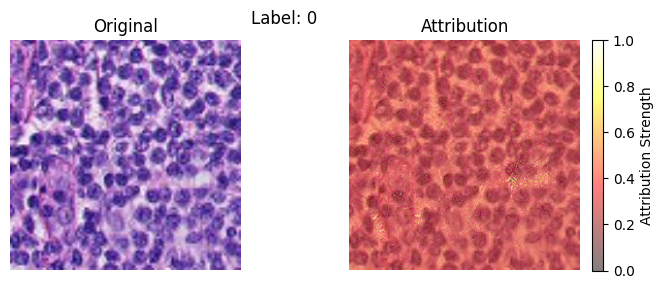

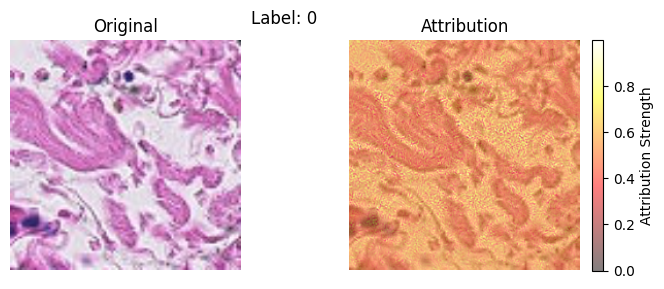

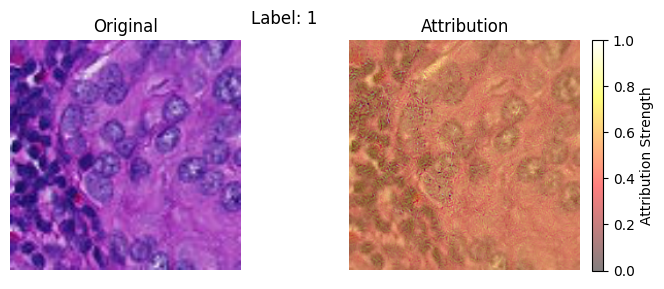

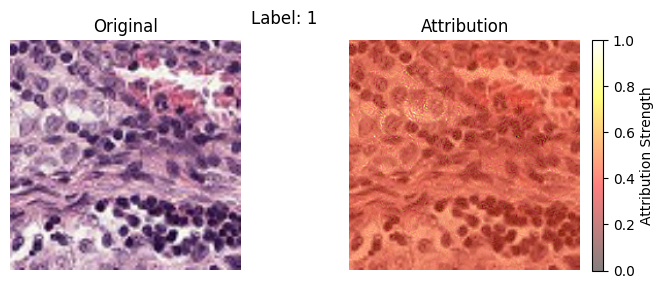

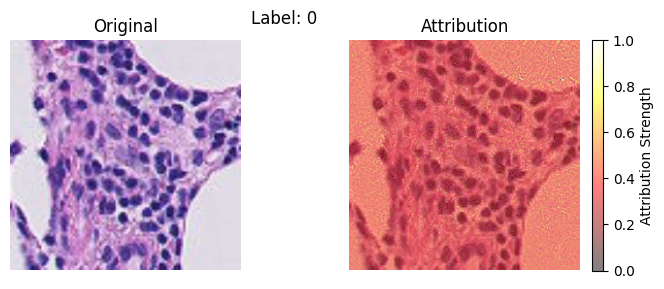

In [8]:


# 1. Unwrap DataParallel model if needed
# model_for_xai = cifar_model.module if isinstance(cifar_model, torch.nn.DataParallel) else cifar_model
model_for_xai = pcam_model.module if isinstance(pcam_model, torch.nn.DataParallel) else pcam_model
model_for_xai.eval()

# 2. Select 5 test images and their labels
# dataiter = iter(cifar10_test_loader)
dataiter = iter(pcam_test_loader)
images, labels = next(dataiter)
images, labels = images[5:10], labels[5:10]
images = images.to(device)
labels = labels.to(device)

# 3. Select baselines for GradientShap (e.g., 10 random images from test set)
# GradientShap works best with multiple baselines
# dataiter = iter(cifar10_test_loader)
dataiter = iter(pcam_test_loader)
baseline_batch, _ = next(dataiter)
num_baselines = 20
if baseline_batch.shape[0] < num_baselines:
    # If batch smaller than 10, repeat as needed
    repeats = (num_baselines // baseline_batch.shape[0]) + 1
    baseline_batch = baseline_batch.repeat(repeats, 1, 1, 1)
baselines = baseline_batch[:num_baselines].to(device)

# 4. Initialize GradientShap
gs = GradientShap(model_for_xai)

# 5. Compute attributions
# For GradientShap, you can pass multiple baselines and the method will average over them
attributions = gs.attribute(images, baselines=baselines, target=labels, n_samples=50, stdevs=0.0)

print(f"Model device: {next(model_for_xai.parameters()).device}")
print(f"Images device: {images.device}")
print(f"Baselines device: {baselines.device}")

# 6. Visualize attributions for each image
def show_attribution(img, attr, title=""):
    img = img.cpu().numpy().transpose(1,2,0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    attr = attr.cpu().detach().numpy().sum(axis=0)
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    fig, axs = plt.subplots(1, 2, figsize=(8,3))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis('off')
    im = axs[1].imshow(img)
    heatmap = axs[1].imshow(attr, cmap='hot', alpha=0.5)
    axs[1].set_title("Attribution")
    axs[1].axis('off')
    # Add colorbar for the heatmap
    plt.colorbar(heatmap, ax=axs[1], fraction=0.046, pad=0.04, label='Attribution Strength')
    plt.suptitle(title)
    plt.show()


for i in range(5):
    show_attribution(images[i], attributions[i], title=f"Label: {labels[i].item()}")


Model device: cuda:0
Images device: cuda:0
Baselines device: cuda:0


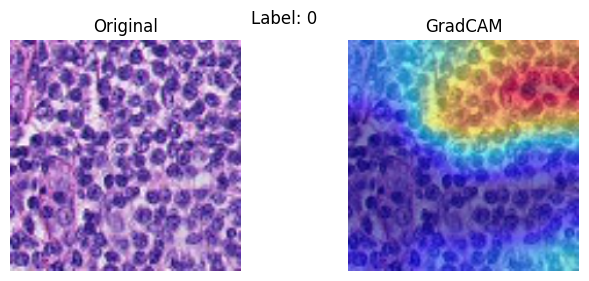

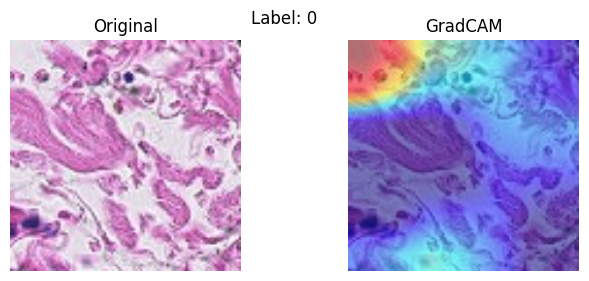

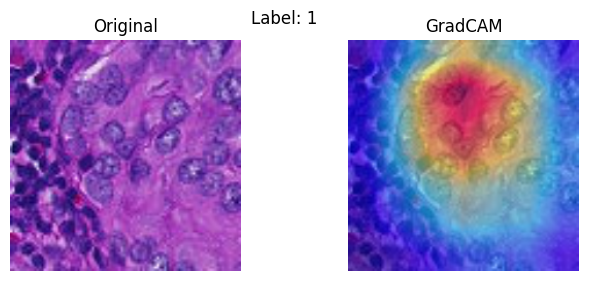

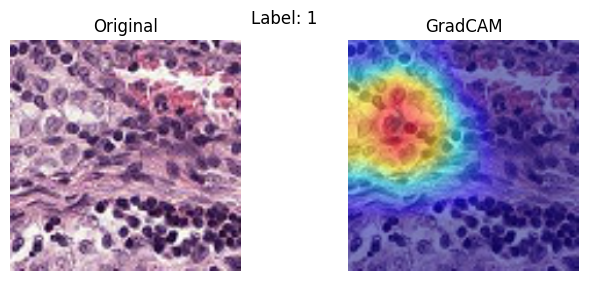

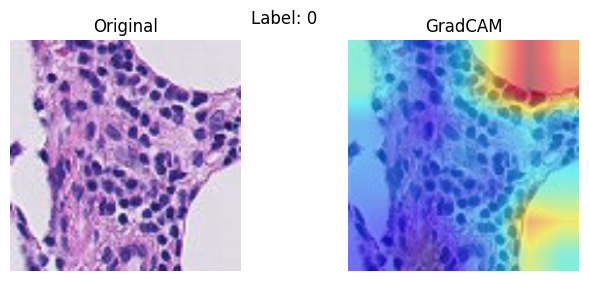

In [9]:


# 1. Unwrap DataParallel if needed
# model_for_xai = cifar_model.module if isinstance(cifar_model, torch.nn.DataParallel) else cifar_model
model_for_xai = pcam_model.module if isinstance(pcam_model, torch.nn.DataParallel) else pcam_model

model_for_xai.eval()

# 2. Select 5 test images and their labels
# dataiter = iter(cifar10_test_loader)
dataiter = iter(pcam_test_loader)
images, labels = next(dataiter)
images, labels = images[5:10], labels[5:10]
images = images.to(device)
labels = labels.to(device)

# 3. Prepare images for visualization (unnormalize to [0,1] for overlay)
def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    return np.clip(img, 0, 1)

rgb_imgs = [unnormalize(images[i]) for i in range(5)]

# 4. Set up GradCAM
target_layers = [model_for_xai.layer4[-1]]
cam = GradCAM(model=model_for_xai, target_layers=target_layers)

print(f"Model device: {next(model_for_xai.parameters()).device}")
print(f"Images device: {images.device}")
print(f"Baselines device: {baselines.device}")

# 5. Run GradCAM for each image
for i in range(5):
    input_tensor = images[i].unsqueeze(0)  # Shape: [1, 3, 224, 224]
    target = [ClassifierOutputTarget(labels[i].item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]  # Shape: [224, 224]
    visualization = show_cam_on_image(rgb_imgs[i], grayscale_cam, use_rgb=True)
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(rgb_imgs[i])
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title("GradCAM")
    plt.axis('off')
    plt.suptitle(f"Label: {labels[i].item()}")
    plt.show()


<h1>This is for XAI AL but for specific cases</h1>

In [ ]:

# ---- TorchWrapper ----
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
    
    def fit(self, train_loader, epochs=5):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    

    
# ---- Overlay center box on image ----
def overlay_center_box(img, mean, std, box_size=32, color="lime", width=2):
    """
    img: torch tensor [C, H, W], normalized
    mean, std: lists or arrays of length 3 (for unnormalization)
    """
    # Unnormalize
    img_disp = img.clone()
    for c in range(3):
        img_disp[c] = img_disp[c] * std[c] + mean[c]
    img_disp = (img_disp * 255).clamp(0,255).to(torch.uint8)

    # Box coordinates for 96x96 image
    H, W = img_disp.shape[1:]
    xmin = (W - box_size) // 2
    ymin = (H - box_size) // 2
    xmax = xmin + box_size
    ymax = ymin + box_size
    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.int)

    # Draw box
    boxed_img = draw_bounding_boxes(img_disp, boxes, colors=color, width=width)
    return boxed_img.permute(1,2,0).cpu().numpy() / 255.0  # For plt.imshow

# ---- XAI Visualization ----
def unnormalize(img, mean, std):
    # img: [C,H,W] torch or np array
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    img = img.transpose(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_xai(images, labels, model, gradshap, gradcam, device, idxs, mean, std,
    class_names=["Normal", "Cancer"], baseline_loader=pcam_train_loader, n_baselines=10):
    
    model.eval()
    images = images.to(device)
    labels = labels.to(device)

    # --- Get multiple random baselines ---
    if baseline_loader is not None:
        baseline_imgs = []
        for b_images, _ in baseline_loader:
            baseline_imgs.append(b_images)
            if sum(x.shape[0] for x in baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs, dim=0)[:n_baselines].to(device)
    else:
        baseline_imgs = torch.zeros((n_baselines, *images.shape[1:]), device=device)

    # Model predictions
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
    labels_np = labels.cpu().numpy()

    # GradientShap attributions (with multiple baselines)
    attr_gs = gradshap.attribute(images, baselines=baseline_imgs, target=labels)
    attr_gs = attr_gs.cpu().numpy()

    # GradCAM attributions
    attr_gc = []
    for i in range(images.shape[0]):
        input_tensor = images[i].unsqueeze(0)
        target = [ClassifierOutputTarget(labels[i].item())]
        grayscale_cam = gradcam(input_tensor=input_tensor, targets=target)[0]
        attr_gc.append(grayscale_cam)
    attr_gc = np.stack(attr_gc)

    # Visualization
    for i in range(images.shape[0]):
        # Unnormalize image for display
        img_disp = unnormalize(images[i].cpu(), mean, std)  # [H, W, C], float32, 0-1
        # Overlay center box on unnormalized image for the first subplot
        boxed_img = overlay_center_box(images[i].cpu(), mean, std, box_size=int(img_disp.shape[0] * 32 / 96), color="lime", width=2)
        gs_map = np.abs(attr_gs[i]).sum(axis=0)
        gs_map = (gs_map - gs_map.min()) / (gs_map.max() - gs_map.min() + 1e-8)
        gc_map = attr_gc[i]
        gc_map = (gc_map - gc_map.min()) / (gc_map.max() - gc_map.min() + 1e-8)

        # Prepare class names for display
        true_cls = labels_np[i]
        pred_cls = preds[i]
        if class_names is not None:
            true_cls_str = class_names[true_cls]
            pred_cls_str = class_names[pred_cls]
        else:
            true_cls_str = str(true_cls)
            pred_cls_str = str(pred_cls)

        # Plotting
        plt.figure(figsize=(12,3))

        # 1. Original image with box
        plt.subplot(1,3,1)
        plt.imshow(boxed_img)
        plt.title(f"idx={idxs[i]}\nTrue: {true_cls_str}\nPred: {pred_cls_str}")
        plt.axis('off')

        # 2. GradientShap with colorbar
        plt.subplot(1,3,2)
        plt.imshow(img_disp)
        im_gs = plt.imshow(gs_map, cmap='hot', alpha=0.5)
        plt.title("GradientShap\n(Red = High Attribution)")
        plt.axis('off')
        cbar = plt.colorbar(im_gs, fraction=0.046, pad=0.04)
        cbar.set_label('Attribution Intensity', rotation=270, labelpad=15)

        # 3. GradCAM with colorbar
        plt.subplot(1,3,3)
        plt.imshow(img_disp)
        im_gc = plt.imshow(gc_map, cmap='jet', alpha=0.5)
        plt.title("GradCAM\n(Yellow/Red = High Activation)")
        plt.axis('off')
        cbar = plt.colorbar(im_gc, fraction=0.046, pad=0.04)
        cbar.set_label('Activation', rotation=270, labelpad=15)

        plt.tight_layout()
        plt.show()


def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return acc, prec, rec, f1


# ---- Main XAL loop with visualization ----
def xal_with_visuals(dataset, model, mean, std, init_size=100, query_size=50, n_cycles=5, batch_size=512, workers=8, xai_image_size=5, test_loader=None):
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    gradshap = GradientShap(model)
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(model=model_for_gc, target_layers=[model_for_gc.layer4[-1]])

    all_indices = np.arange(len(dataset))
    np.random.seed(42)
    labeled_indices = np.random.choice(all_indices, size=init_size, replace=False)
    unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)
    unlabeled_subset_xai = Subset(dataset, unlabeled_indices)
    fixed_xai_indices = np.random.choice(unlabeled_indices, size=xai_image_size, replace=False)
    xai_subset = Subset(unlabeled_subset_xai, fixed_xai_indices)
    xai_loader = DataLoader(xai_subset, batch_size=xai_image_size, shuffle=False)
    xai_images, xai_labels = next(iter(xai_loader))

    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        
        # --- XAI visualization before training ---
        print("XAI visualizations for fixed samples:")
        show_xai(xai_images, xai_labels, model, gradshap, gradcam, device, fixed_xai_indices, np.array(mean), np.array(std))

        # --- Training ---
        train_subset = Subset(dataset, labeled_indices)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                 num_workers=workers, pin_memory=True, persistent_workers=True)
        wrapper.fit(train_loader, epochs=20)

        # --- Performance Evaluation ---
        if test_loader is not None:
            acc, prec, rec, f1 = evaluate_model(model, test_loader, device)
            print(f"Test Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}| F1: {f1:.3f}")

        # --- Active Sampling ---
        unlabeled_subset = Subset(dataset, unlabeled_indices)
        unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=False,
                                     num_workers=workers, pin_memory=True, persistent_workers=True)
        probs = wrapper.predict_proba(unlabeled_loader)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        query_indices = np.argsort(-entropy)[:query_size]
        newly_selected = unlabeled_indices[query_indices]

        labeled_indices = np.concatenate([labeled_indices, newly_selected])
        unlabeled_indices = np.setdiff1d(unlabeled_indices, newly_selected)

        if len(unlabeled_indices) == 0:
            print("Unlabeled pool exhausted.")
            break









=== AL Cycle 1 | Labeled: 100 samples ===


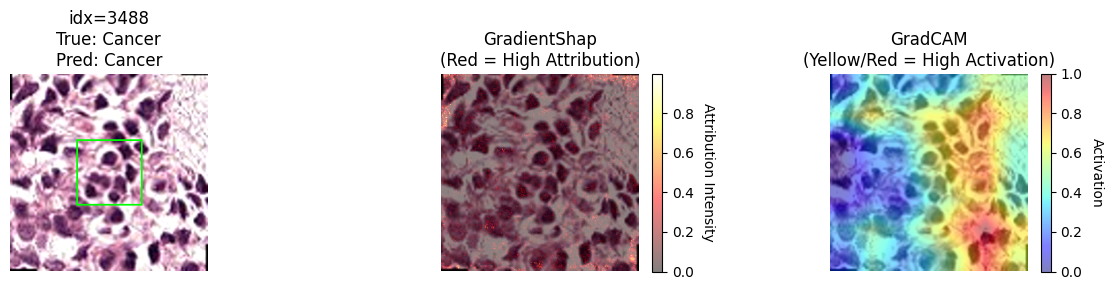

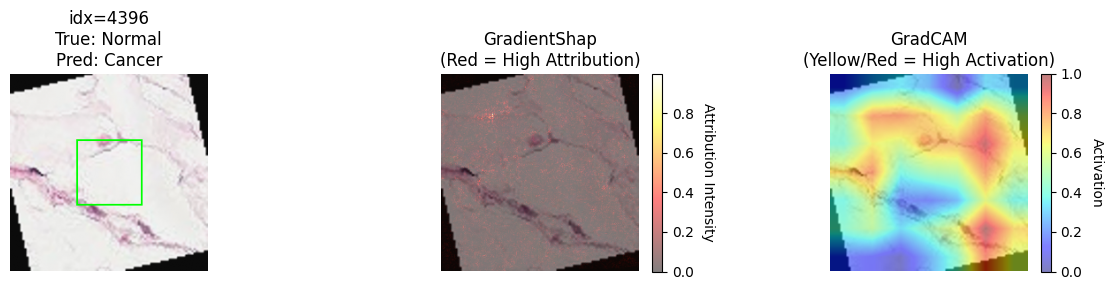

Validation → Acc: 0.551 | Prec: 0.516 | Rec: 0.962 | F1: 0.672


TypeError: UncertaintySampling.query() got an unexpected keyword argument 'proba'

In [ ]:
# xal_with_visuals(pcam_train_subset, pcam_model, IMAGENET_MEAN, IMAGENET_STD,test_loader=pcam_test_loader,
# init_size=100, query_size=50, n_cycles=10, batch_size=2200, workers=30, xai_image_size = 2)

In [ ]:

# ================== TORCH WRAPPER WITH EARLY STOPPING ==================
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
        self.best_weights = None
        
    def fit(self, train_loader, val_loader=None, epochs=5, patience=3):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation and early stopping
            if val_loader:
                val_loss = 0.0
                self.model.eval()
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images = val_images.to(self.device)
                        val_labels = val_labels.to(self.device)
                        outputs = self.model(val_images)
                        val_loss += criterion(outputs, val_labels).item()
                
                avg_val_loss = val_loss / len(val_loader)
                print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    self.best_weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered!")
                        self.model.load_state_dict(self.best_weights)
                        break

    def predict_proba(self, data_loader):
        self.model.eval()
        probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs.append(torch.softmax(outputs, dim=1).cpu())
        return torch.cat(probs).numpy()

# ================== VISUALIZATION UTILITIES ==================
def overlay_center_box(img, mean, std, box_size=32, color="lime", width=2):
    img_disp = img.clone()
    for c in range(3):
        img_disp[c] = img_disp[c] * std[c] + mean[c]
    img_disp = (img_disp * 255).clamp(0,255).to(torch.uint8)
    
    H, W = img_disp.shape[1:]
    xmin = (W - box_size) // 2
    ymin = (H - box_size) // 2
    boxes = torch.tensor([[xmin, ymin, xmin+box_size, ymin+box_size]], dtype=torch.int)
    boxed_img = draw_bounding_boxes(img_disp, boxes, colors=color, width=width)
    return boxed_img.permute(1,2,0).cpu().numpy() / 255.0

def unnormalize(img, mean, std):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    img = img.transpose(1,2,0)
    return np.clip(img * std + mean, 0, 1)

# ================== XAI VISUALIZATION ==================
def show_xai(images, labels, model, gradshap, gradcam, device, idxs, mean, std,
             class_names=["Normal", "Cancer"], baseline_loader=None, n_baselines=10):
    
    # Handle DataParallel models
    if isinstance(model, torch.nn.DataParallel):
        model_for_gc = model.module
    else:
        model_for_gc = model
        
    model.eval()
    images = images.to(device)
    labels = labels.to(device)

    # Get baselines
    if baseline_loader is not None:
        baseline_imgs = []
        for b_images, _ in baseline_loader:
            baseline_imgs.append(b_images.to(device))
            if len(baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
    else:
        baseline_imgs = torch.randn(n_baselines, *images.shape[1:], device=device)

    # Compute explanations
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
    
    # GradientShap
    attr_gs = gradshap.attribute(images, baselines=baseline_imgs, target=labels).cpu().numpy()
    
    # GradCAM++
    gradcam_output = gradcam(input_tensor=images,
                            targets=[ClassifierOutputTarget(l.item()) for l in labels],
                            aug_smooth=True)
    
    # Visualization
    for i in range(images.shape[0]):
        img = images[i].cpu()
        img_disp = unnormalize(img, mean, std)
        boxed_img = overlay_center_box(img, mean, std)
        
        plt.figure(figsize=(12, 3))
        
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(boxed_img)
        plt.title(f"ID {idxs[i]}\nTrue: {class_names[labels[i].item()]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # GradientShap
        plt.subplot(1,3,2)
        gs_map = np.abs(attr_gs[i]).sum(0)
        gs_map = (gs_map - gs_map.min()) / (gs_map.max() - gs_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gs_map, cmap='hot', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradientSHAP")
        plt.axis('off')

        # GradCAM++
        plt.subplot(1,3,3)
        gc_map = gradcam_output[i]
        gc_map = (gc_map - gc_map.min()) / (gc_map.max() - gc_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gc_map, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradCAM++")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# ================== EVALUATION FUNCTION ==================
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return (
        accuracy_score(all_labels, all_preds),
        precision_score(all_labels, all_preds, zero_division=0),
        recall_score(all_labels, all_preds, zero_division=0),
        f1_score(all_labels, all_preds, zero_division=0)
    )

# ================== ACTIVE LEARNING LOOP ==================
def xal_with_visuals(dataset, model, mean, std, init_size=100, query_size=50, 
                    n_cycles=5, batch_size=512, workers=8, xai_image_size=5,
                    test_loader=None, val_loader=None, recall_threshold=0.85):
    
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    
    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = gradcam(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]],
        use_cuda=torch.cuda.is_available()
    )
    
    gradshap = GradientShap(model)

    # Initial pool setup
    all_indices = np.arange(len(dataset))
    np.random.seed(42)
    labeled_indices = np.random.choice(all_indices, init_size)
    unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)
    
    # Fixed XAI watchlist
    fixed_xai_indices = np.random.choice(unlabeled_indices, xai_image_size, replace=False)
    xai_subset = Subset(dataset, fixed_xai_indices)
    xai_loader = DataLoader(xai_subset, batch_size=xai_image_size, shuffle=False)
    xai_images, xai_labels = next(iter(xai_loader))

    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        
        # XAI visualization
        show_xai(xai_images, xai_labels, model, gradshap, gradcam, device, 
                fixed_xai_indices, np.array(mean), np.array(std))

        # Training
        train_loader = DataLoader(Subset(dataset, labeled_indices), 
                                batch_size=batch_size, shuffle=True,
                                num_workers=workers, pin_memory=True,
                                persistent_workers=True)
        wrapper.fit(train_loader, val_loader=val_loader, epochs=20, patience=3)

        # Validation check
        if val_loader:
            _, _, val_rec, _ = evaluate_model(model, val_loader, device)
            if val_rec >= recall_threshold:
                print(f"★ Stopping: Validation Recall ≥ {recall_threshold} ★")
                break

        # Active sampling
        unlabeled_loader = DataLoader(Subset(dataset, unlabeled_indices),
                                    batch_size=batch_size, shuffle=False,
                                    num_workers=workers, pin_memory=True,
                                    persistent_workers=True)
        probs = wrapper.predict_proba(unlabeled_loader)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        query_idx = np.argsort(-entropy)[:query_size]
        labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
        unlabeled_indices = np.delete(unlabeled_indices, query_idx)

        if len(unlabeled_indices) == 0:
            print("★ Unlabeled pool exhausted ★")
            break

    return model



In [ ]:
# Run active learning
final_model = xal_with_visuals(
    dataset=pcam_train_subset,
    model=model,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    init_size=200,
    query_size=100,
    n_cycles=20,
    batch_size=512,
    workers=24,
    val_loader=pcam_val_loader,
    test_loader=pcam_test_loader,
    recall_threshold=0.85
)

In [8]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:



In [9]:
# For CIFAR-10
# cifar_class_names = cifar10_train.classes
# cifar_results = evaluate_model(cifar_model, cifar10_test_loader, device, class_names=cifar_class_names)

# For PCam
pcam_class_names = ['Negative', 'Positive']
pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)

Accuracy: 0.7869
Accuracy for Negative: 0.8290 (4959 samples)
Accuracy for Positive: 0.7455 (5041 samples)

Confusion Matrix:
[[4111  848]
 [1283 3758]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.83      0.79      4959
    Positive       0.82      0.75      0.78      5041

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

